[Next]() | [Prev](Audio_Classification_Algorithms.htm) | [DLfMIR Home](https://iranroman.github.io/DLfMIR)

---

# Chapter 3: Using Regression to Train a Classifier #

### Subsections ###
1. Finding Relationships Between Audio Features with Linear Regression
2. Using Regression to Classify Different Musical Objects
3. Developing and Assessing a Naïve Classification Algorithm

### 3.1 Finding Relationships Between Audio Features with Linear Regression ###
In Chapter 2 we learned how to identify the timbre of four different musical instruments by traing and testing a naïve classifier. As you remember, we used a vector of average features for each of the instrument classes to compute its inner product with other datapoints. The results we obtained from this classifier were nowhere close to 100% in neither the training nor the testing data. In this chapter we will learn how to use Regression, which will improve the accuracy of our model by finding better vectors than the vectors with average features we used before. 

Let's start with the basics. Linear regression consists on finding a collection of scalars $\beta \in \mathbf{R^{1xN}}$ that will multiply element-wise a feature space $x \in \mathbf{R^{1xN}}$, so that when we add all the products we maximally approximate a desired scalar $y \in \mathbf{R^{1}}$. The formula of regression is:
$$\hat{y} = \sum_{i=0}^{N-1} \beta_i x_i = \beta_0x_0 + \beta_1x_1 + \beta_2x_2 + \dots + \beta_{n-1}x_{n-1}$$

Where $\hat{y}$ is the closes we can get to $y$ when multiplying element-wise $x$ and $\beta$. This formula is known as linear regression because the formula is exactly the same as the equation of a [line](https://en.wikipedia.org/wiki/Linear_equation). We also see that all the coefficients and their products are first-degree operations in this formula. If we were to compute either the power or the root of a $\beta$ coefficient, we would be computing a [non-linear function](https://en.wikipedia.org/wiki/Nonlinear_system).

To gain a better intution for linear regression, we will use the small version of the [IRMAS dataset](https://www.upf.edu/web/mtg/irmas) to identify linear relationships between two features: the spectral centroid and the spectral bandwidth. Let's start by loading the dataset, extracting these features, and plotting them for all the datapoints.

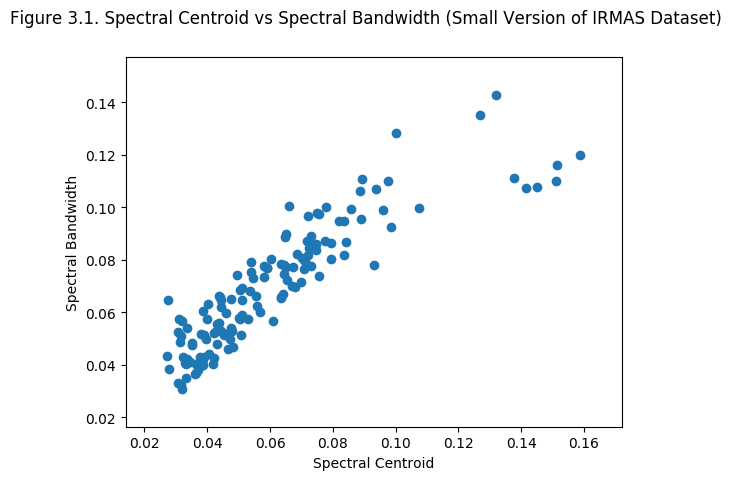

In [2]:
# a package to load data in .mat files
using MAT
using DSP

# loading a small version of the IRMAS dataset 
iris = matread("IRMAS_small.mat")
fs = 22050 # storing the sampling rate in a variable
T = 1/fs # and the timestep

# obtaining the data and corresponding instrument categories
data = iris["data"][:,1:end-1]
inst_cat = iris["data"][:,end];

# Remembering the number of datapoints in data and their dimensionality
N, D = size(data)

# declaring general parameters for the spectrogram
frlength = floor(Int,D/80) # frame length
noverlap = floor(Int,D/200) # number of samples overlapping between frames

# initialize a new matrix to store the reduced data
centData = zeros(N,4)

# let's iterate over the datapoints
for i = 1:N
   
    # calculate the spectrogram for each datapoint like we have done before
    X = spectrogram(data[i,:], frlength, noverlap, nfft=nextpow2(frlength), window=hanning)

    # extract the spectrogram parameters that we will need
    f = freq(X)
    X = power(X)

    # to calculate the spectral centroid for each timebin
    # first multiply the magnitudes by the frequency bins
    fX = f.*sqrt.(X)
    # next sum the values in fX for each timebin
    fXsum = sum(fX,1)
    # then sum the values in sqrt.(X) for each timebin
    Xsum = sum(sqrt.(X),1)
    # now divide fXsum by Xsum
    centroids = fXsum./Xsum
    # finally compute the mean and standard deviation
    meanCent = mean(centroids)
    stdCent = std(centroids)

    # to calculate the power spectral centroid for each timebin
    # first multiply the power by the frequency bins
    fX = f.*X
    # next sum the values in fX for each timebin
    fXsum = sum(fX,1)
    # then sum the values in X for each timebin
    Xsum = sum(X,1)
    # now divide fXsum by Xsum
    centroids = fXsum./Xsum
    # finally compute the mean and standard deviation
    meanPCent = mean(centroids)
    stdPCent = std(centroids)
    
    # and store these values for later use
    centData[i,:] = [meanCent stdCent meanPCent stdPCent]

end

# Remembering the number of datapoints in data and their dimensionality
N, D = size(data)

# declaring general parameters for the spectrogram
frlength = floor(Int,D/80) # frame length
noverlap = floor(Int,D/200) # number of samples overlapping between frames

# initialize a new matrix to store the reduced data
SBData = zeros(N,4)

# let's iterate over the datapoints
for i = 1:N
   
    # calculate the spectrogram for each datapoint like we have done before
    X = spectrogram(data[i,:], frlength, noverlap, nfft=nextpow2(frlength), window=hanning)

    # extract the spectrogram parameters that we will need
    f = freq(X)
    X = power(X)

    # to calculate the spectral centroid for each timebin    
    # first multiply the magnitudes by the frequency bins 
    fX = f.*sqrt.(X)
    # next sum the values in fX for each timebin
    fXsum = sum(fX,1)
    # then sum the values in sqrt.(X) for each timebin
    Xsum = sum(sqrt.(X),1)
    # now divide fXsum by Xsum
    centroids = fXsum./Xsum

    # to calculate the spectral bandwidth for each timebin
    # first subtract the spectral centroids from the frequency bins 
    # and raise to the power of 2
    fminc = (f.*ones(size(X)) .- centroids).^2
    # next multiply fminc by the spectral magnitudes sqrt.(X)
    devs = fminc.*sqrt.(X)
    # sum the values in each timebin of devs and 
    # divide them by the sum of values in each timebin of sqrt.(X)
    # also take the square root of everything
    SBs = sqrt.(sum(devs,1)./sum(sqrt.(X),1))
    
    # finally compute the mean and standard deviation
    meanSB = mean(SBs)
    stdSB = std(SBs)

    # to calculate the power spectral centroid for each timebin
    # first multiply the power by the frequency bins
    fX = f.*X
    # next sum the values in fX for each timebin
    fXsum = sum(fX,1)
    # then sum the values in X for each timebin
    Xsum = sum(X,1)
    # now divide fXsum by Xsum
    centroids = fXsum./Xsum
    
    # to calculate the power spectral bandwidth for each timebin
    # first subtract the spectral centroids from the frequency bins 
    # and raise to the power of 2
    fminc = (f.*ones(size(X)) .- centroids).^2
    # next multiply fminc by the spectral powers X
    devs = fminc.*X
    # sum the values in each timebin of devs and 
    # divide them by the sum of values in each timebin of X
    # also take the square root of everything
    SBs = sqrt.(sum(devs,1)./sum(X,1))    
    
    # finally compute the mean and standard deviation
    meanPSB = mean(SBs)
    stdPSB = std(SBs)
    
    # and store these values for later use
    SBData[i,:] = [meanSB stdSB meanPSB stdPSB]

end

using PyPlot
scatter(centData[:,1],SBData[:,1])
xlabel("Spectral Centroid")
ylabel("Spectral Bandwidth")

suptitle("Figure 3.1. Spectral Centroid vs Spectral Bandwidth (Small Version of IRMAS Dataset)");

In this plot we see values for the two features (spectral centroid and spectral bandwidth) associated with each datapoint. A general relationship between these two features is that they are positively correlated with each other (i.e. the spectral centroid values grow as the spectral bandwidth values grow). With these two features and these datapoints, we can carry out regression to find a line $\hat{y}$ that is maximally aligned with the data. This will will allow us to estimate spectral bandwidth values, given a spectral centroid value.

To carry out regression, we need two things: 

1. An equation describing the relationship we want to establish between the independent variable $x$ (here the spectral centroid) and the dependent variable $y$ (here the spectral bandwidth). For us this is:
$$\hat{y} = \sum_{i=0}^{N-1} \beta_i x_i = \beta_0x_0 + \beta_1x_1 + \beta_2x_2 + \dots + \beta_{n-1}x_{n-1}$$
2. An objective that indicates the relationship we want to find between $\hat{y}$ and $y$. For us, this could be: $$minimize\{|y - \hat{y}|\} \qquad \text{or} \qquad minimize\bigg\{\sqrt{(y - \hat{y})^2}\bigg\}$$

These two objectives are different mathematical functions. The first one is the L1 norm (a.k.a [Taxicab norm](https://en.wikipedia.org/wiki/Taxicab_geometry)) while the second one is the L2 norm (a.k.a Euclidean distance). But in essence both do the same thing: minimize the difference between $\hat{y}$ and $y$.

Let's go back to the specific example that we plotted in Figure 3.1. Given all the datapoints we have, we want to find a linear relationship between spectral centroid and spectral bandwidth. For each datapoint $x$ is the spectral centroid ($x \in \mathbf{R^1}$) and $y$ is its corresponding spectral bandwidth. The relationship between $x$ and $y$ for each datapoint is described by the expression $y = \beta x$. In this expression we know $y$ and we also know $x$. We have one equation and one unknown ($\beta \in \mathbf{R^1}$), so for each datapoint, we can find a $\beta$ that perfectly fulfills the relationship by solving: $\beta = \frac{y}{x}$. However, what we want to find is the linear relationship between spectral centroid and spectral bandwidth across all datapoints. Doing this is more complex, because there is not a single $\beta$ that fits all datapoints. Hence, our job is to find the $\beta$ that minimizes the difference between $\hat{y}$ and $y$. Hence, our objective is described by the expression:
$$minimize\{\sqrt{(y - \hat{y})^2}\} = minimize\bigg\{\sqrt{(y - \beta x)^2}\bigg\} $$

There are multiple ways of fnding the $\beta$ that best possibly describes the linear relationship between spectral centroid and spectral bandwidth across all datapoints. Here we will use the derivative of the objective with respect to $\beta$ in order to move along the possible values in the [domain and range](https://www.khanacademy.org/math/algebra/algebra-functions/domain-and-range/v/domain-of-a-function-intro) of the objective function. We can assume that we have no idea what the best value of $\beta$ will be and just set it to be a random number. We compute $\hat{y}$ for all datapoints in our dataset and find what the average objective across al datapoints:
$$minimize\bigg\{\frac{1}{N}\sum_i\{\sqrt{(y_i - \hat{y_i})^2}\bigg\}$$

Our goal is to minimize the objective. To reduce the objective, we must find a better $\beta$. We can find the gradient of the objective function with respect to $\beta$ to update $\beta$ in the following way:

$$\beta := \beta - \gamma \frac{1}{N}\sum_i\frac{\partial \sqrt{(y_i - \hat{y_i})^2}}{\partial \beta}$$

Where $\gamma$ is a parameter known as the learning rate that we have to select. To calculate the derivative $\frac{\partial \sqrt{(y_i - \hat{y_i})^2}}{\partial \beta}$ we will need to use the [chain rule](https://en.wikipedia.org/wiki/Chain_rule) as well as the [power rule](https://en.wikipedia.org/wiki/Power_rule). Fill in the missing steps to calculate the derivative below:

$$\begin{align}
\frac{\partial \sqrt{(y_i - \hat{y_i})^2}}{\partial \beta} &= \frac{\partial \sqrt{(y_i - \hat{y_i})^2}}{\partial (y_i - \hat{y_i})^2}\frac{\partial (y_i - \hat{y_i})^2}{\partial \beta} \\ &= \frac{1}{2}\big((y_i - \hat{y_i})^2\big)^{-\frac{1}{2}}\frac{\partial (y_i - \hat{y_i})^2}{\partial (y_i - \hat{y_i})}\frac{\partial(y_i - \hat{y_i})}{\partial \beta} \\ &= \frac{1}{2}\big((y_i - \hat{y_i})^2\big)^{-\frac{1}{2}}2(y_i - \hat{y_i})(\frac{\partial y_i}{\partial \beta}-\frac{\partial \hat{y_i}}{\partial \beta}) \\ &= -\frac{(y_i - \hat{y_i})}{\sqrt{(y_i - \hat{y_i})^2}}\frac{\partial \beta x_i}{\partial \beta} \\ &= -\frac{x_i(y_i - \hat{y_i})}{\sqrt{(y_i - \hat{y_i})^2}} \\ &= -\frac{x_i(y_i - \beta x_i)}{\sqrt{(y_i - \beta x_i)^2}}
\end{align}$$

Now that we know how to update $\beta$, we can iterate over the data to minimize the objective:

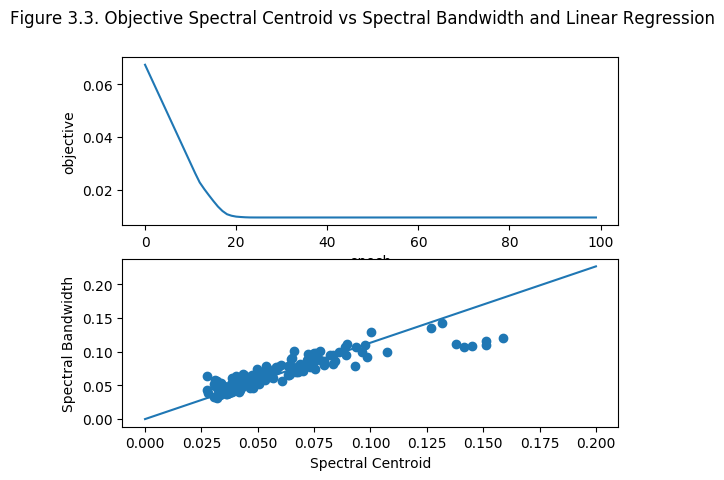

In [104]:
x = centData[:,1]
y = SBData[:,1]

beta = 0.1*randn(1,1)

lr = 1

nepochs = 100;

objectives = zeros(nepochs,1)

for epoch = 1:nepochs

y_hat = x.*beta

objective = mean(sqrt((y_hat - y).^2))

objectives[epoch,1] = objective
    
dOdb = -x.*(y - y_hat)./(sqrt((y_hat - y).^2))

beta = beta - lr*mean(dOdb)
    
end

subplot(2,1,1)
plot(objectives)
xlabel("epoch")
ylabel("objective")
subplot(2,1,2)
scatter(centData[:,1],SBData[:,1])
plot(linspace(0,0.2,10),beta.*linspace(0,0.2,10))
xlabel("Spectral Centroid")
ylabel("Spectral Bandwidth")

suptitle("Figure 3.3. Objective Spectral Centroid vs Spectral Bandwidth and Linear Regression");

A better linear function to carry out regression is one that also contains a bias term. We can update our objective to be:
$$minimize\{\sqrt{(y - \hat{y})^2}\} = minimize\bigg\{\sqrt{(y - (\beta_0 \beta_1 x))^2}\bigg\} $$

where $\beta_0$ is a bias term that will make the regression line not necessarily intersect the y axis at 0. We can estimate where $\beta_0$ must lay around by looking at the data, but we can also find it using the derivative of the objective function with respect to it. Hence we now have to optimize two parameters with the data:
$$\beta_0 := \beta_0 - \gamma \frac{1}{N}\sum_i\frac{\partial \sqrt{(y_i - \hat{y_i})^2}}{\partial \beta_0}$$
$$\beta_1 := \beta_1 - \gamma \frac{1}{N}\sum_i\frac{\partial \sqrt{(y_i - \hat{y_i})^2}}{\partial \beta_1}$$

Find the derivative for each of this parameters and carry out the optimization in the cell bellow.

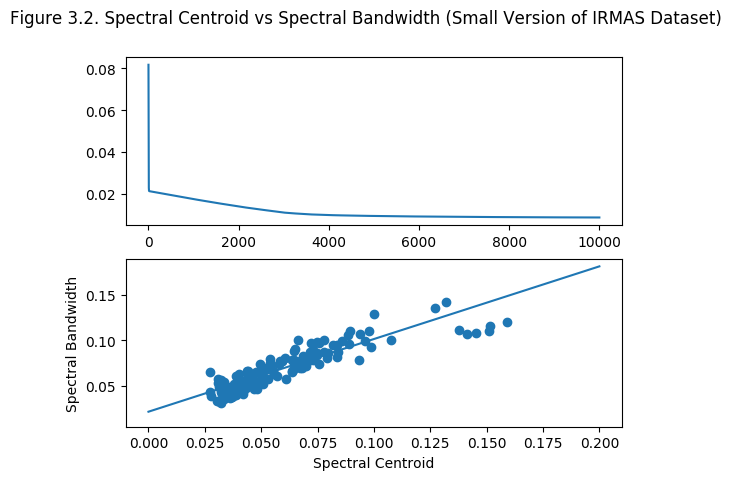

### 3.2 Using Regression to Classify Different Musical Objects ###
Now that we have gained intution about how regression works, we can return to our classification problem and apply regression to it. Remember that we used four "average" or "template" vectors for classify datapoints as belonging to four different musical instrument categories. As you remember, we had not so great results using the average vectors we calculated. Using regression we might be able to find a better $W$ matrix.

To better unsderstand the problem, think about the $W \in \mathbf{R^{3x4}}$ matrix as parameters of the mathematical function $$y ~= ~u ~W$$

Where $u \in \mathbf{R^{1x3}}$ is an unknown datapoint, and the vector $y \in \mathbf{R^{1x4}}$ contains the "score" of similarity between vector $u$ and each of the color vectors. 

Now, instead of $u$, let's use a labeled datapoint $x \in \mathbf{R^{1x2}}$. Hence, we can make the mathematical function not just a function, but an "objective". What would the objective be?

We can say that the objective is to make the score for the true color of $x$ to be as high as possibe 

$J = \text{Maximize} \{\hat{y}_{correct}\}$

Where $\hat{y}_{correct} \in \hat{y}$

Thankfully, this is a mathematical function and, assuming it is differentiable, we can take the derivative of the objective w.r.t the parameters $W$ and "ascend" to a higher score for the correct label. 

Hence, we have:

$\frac{\partial J}{\partial W}$

From here on, we use the chain rule to expand this expression into:

$\frac{\partial J}{\partial W} ~= \big(~\frac{\partial \hat{y}}{\partial W}\big)^T ~\frac{\partial J}{\partial \hat{y}} $

Since the objective depends only on $\hat{y}_{correct}$ (i.e. we only care about the score contained in $\hat{y}_{correct}$), the derivative of $\frac{\partial J}{\partial \hat{y}} = $ ?

The derivative of $\frac{\partial J}{\partial \hat{y}} = e_{correct}$

where $e_{correct}$ is a "one-hot" vector in $\mathbf{R^{1x3}}$. This means that all its entries are zero, except at the index that contained the score for the correct label in $\hat{y}$, where it has a value of one.

Hence, our expression is:

$\frac{\partial J}{\partial W} ~= ~\big(\frac{\partial \hat{y}}{\partial W}\big)^T ~e_{correct} ~= ~\big(\frac{\partial xW}{\partial W}\big)^T ~e_{correct}  ~= ~x^T~e_{correct}$

And an update step in the direction that maximizes the value of the objective function would be:

$W := ~W + ~\alpha~x^T~e_{correct}$

Where $\alpha$ is a tunable free parameter that would allow you to decide how much you want $\frac{\partial J}{\partial W}$ to affect your $W$.

Now let's prove that all the math we just did can actually help a model maximize the score for the correct label of a datapoint.

Start by separating your data into a training and a testing set.

In [3]:
# your code here



Now, generate the trainable matrix `W` with random numbers centered around zero. What should its dimensions be?

Iterate over each of the elements in the training set to apply the update $W := ~W + ~\alpha~x^T~e_{correct}$ that we derived above. 

The goal is to show that the `W` matrix can be changed to maximize the scores for the few datapoints that you are training it with.

If you are done ahead of everyone else. Can you think of a way to do this without a `for` loop? Implement it. 

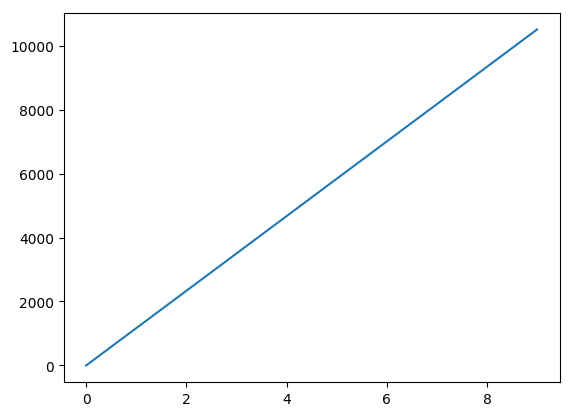

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7ff99e062690>

In [65]:
# generate the W matrix
# [your code here:]


A major limitation with the method described so far is the objective function. 

Just think about it! The score could continue growing forever, so the learning process would never end.

We need to come up with a better objective function. 

How could we change our current objective function $J = \text{Maximize} \{\hat{y}_{correct} ~= ~x ~W\}$ to make it have an upper bound?

A simple manipulation would be to change the objective function to be:

$J = \text{Maximize} \bigg\{\hat{y}_{correct}\bigg\} = \text{Maximize} \bigg\{\big(\frac{~x ~W}{\sum_{i}~x ~W}\big)_{correct}\bigg\}$

Why?

We now use the chain rule to differentiate the expression w.r.t the "trainable" parameters $W$: 

$\frac{\partial J}{\partial W} ~= ~\frac{\partial J}{\partial \hat{y}} ~\frac{\partial \hat{y}}{\partial W}$

$\frac{\partial J}{\partial W} ~= ~\big(\frac{\partial ~x ~W}{\partial W}\big)^T~\frac{\partial J}{\partial \hat{y}} ~\frac{\partial ~\hat{y}}{\partial ~x ~W}$

$\frac{\partial J}{\partial W} ~= ~\big(\frac{\partial ~x ~W}{\partial W}\big)^T~\frac{\partial J}{\partial \hat{y}} ~\frac{\partial ~\frac{~x ~W}{\sum_{i}~x ~W}}{\partial ~x ~W} $

We already know that $\frac{\partial J}{\partial \hat{y}} = e_{correct}$


To find $\frac{\partial ~\frac{~x ~W}{\sum_{i}~x ~W}}{\partial ~x ~W}$, let's define $s = ~x ~W$, where $s$ is short for "scores". We will have to find the jacobian matrix:

$$ \frac{\partial ~\hat{y}}{\partial ~x ~W} = ~\frac{\partial ~\frac{~x ~W}{\sum_{i}~x ~W}}{\partial ~x ~W} = ~\frac{\partial ~\frac{s}{\sum_{i}~s}}{\partial ~s} = ~\begin{bmatrix} \frac{\partial \hat{y}_1}{\partial s_1} & \frac{\partial \hat{y}_1}{\partial s_2} & \dots & \frac{\partial \hat{y}_1}{\partial s_n} \\ \frac{\partial \hat{y}_2}{\partial s_1} & \frac{\partial \hat{y}_2}{\partial s_2}& \dots & \vdots \\ 
\vdots & \vdots & \ddots & \vdots\\
\frac{\partial \hat{y}_n}{\partial s_1} & \frac{\partial \hat{y}_n}{\partial s_2} & \dots & \frac{\partial \hat{y}_n}{\partial s_n} \end{bmatrix}$$

At this point we recognize that the Jacobian matrix $\frac{\partial ~\hat{y}}{\partial ~x ~W}$ will be multiplied by the one-hot vector $e_{correct}$ by the inner product. This will zero out all entries in the Jacobian except: 

$$e_{correct} \frac{\partial ~\hat{y}}{\partial ~x ~W} = ~\begin{bmatrix} \frac{\partial \hat{y}_{correct}}{\partial s_1} & \frac{\partial \hat{y}_{correct}}{\partial s_2} & \dots & \frac{\partial \hat{y}_{correct}}{\partial s_n} \end{bmatrix}$$

And we also observe that:

$$~i = j \rightarrow ~\frac{\partial \hat{y}_i}{\partial s_j} = \frac{\sum_{i\neq j} s}{(\sum s)^2}$$

$$~i \neq j \rightarrow ~\frac{\partial \hat{y}_i}{\partial s_j} = -~\frac{s_i}{(\sum s)^2} = -~\frac{\hat{y}_i}{\sum s}$$

So, to summarize, let's remember:

$\frac{\partial J}{\partial W} ~= ~\big(\frac{\partial ~x ~W}{\partial W}\big)^T~\frac{\partial J}{\partial \hat{y}} ~\frac{\partial ~\frac{~x ~W}{\sum_{i}~x ~W}}{\partial ~x ~W} $

But knowing that $~\frac{\partial J}{\partial \hat{y}} ~\frac{\partial ~\frac{~x ~W}{\sum_{i}~x ~W}}{\partial ~x ~W} = ~\frac{\partial J}{\partial s}$ we can now rewrite everything as:

$\frac{\partial J}{\partial W} ~= ~\big(\frac{\partial ~x ~W}{\partial W}\big)^T ~\frac{\partial J}{\partial s} $

Modify your previous program so that this time the objective function is: $$J = \text{Maximize} \bigg\{\hat{y}_{correct}\bigg\}$$

And the update step in the direction that maximizes the value of the objective function is:

$W := ~W + ~\alpha~\frac{\partial J}{\partial W}$

This time, initialization of `W` must consist of exclusively of positive numbers. Why?

Experiment with changing the $\alpha$ parameter. Hint: you may have to do more than one pass through the training data in order for "learning" to take place.

Do you foresee major caveats?

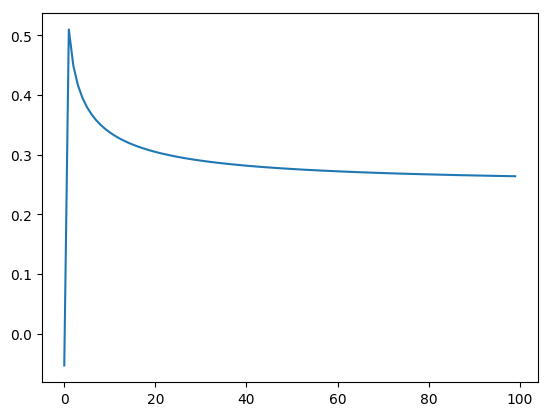

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7ff99cd25c90>

In [112]:
# generate the W matrix
# [your code here:]


Make Julia print the `W` and the `dJ_dW` matrices at every iteration. What did you notice? Could something go wrong?

What makes this a good/bad/better/worse way to make a Neural Network Learn?

Highlight observation in with a group of classmates and be prepared to share with the class. 

The objective function we described previously will return meaningless values when the $W := ~W + ~\alpha~\frac{\partial J}{\partial W}$ update introduces negative values to the $W$ matrix. 

Thankfully, there is are better objective functions to choose. In fact, no one uses the ones we have derived so far (they were just intended as examples to build up intuition from the ground up).

An objective function that is prefered to train Neural Networks is called the $softmax()$ function. 

In spirit $softmax()$ is similar to the objective function $J = \text{Maximize} \bigg\{\hat{y}_{correct}\bigg\}$, but making it bullet-proof to negative numbers.

Before we dive into $softmax()$ though, let's summarize the elements components of a Neural Network we have studied so far.

A simple and generalized Feedforward Neural Netowrk is described by the expression:

$$J = Objective \big\{\hat{y} = ~f(x~W)\big\}$$

* Where $x$ contains a fixed datapoint
* $W$ contains the trainable parameters
* $f()$ is the function setting an upper bound to the scores obtained from the inner product between $x~W$
* and the $Objective \{\}$ determines what we want to maximize (or maybe redude).

Out of the four elements we have been using so far, we can change two to significantly improve the performance of our neural network.

Lets start picking a better function $f()$:
$$softmax(\theta) = \frac{e^\theta}{\sum e^\theta}$$
Here, $\theta \in \mathbf{R^{1xC}}$ is our vector of "scores" for each class.

If you think about it, by raising $e$ to the power of our "scores" vector we make sure that $\hat{y}$ will never have negative values. 

Whenever the "scores" vector contains negative values, raising e to the power of any real number we will obtain a positive value. 

Even $e^{-\infty} = 0$ is a positive number (if you consider $0$ a positive number), but in practive we will never run into this situation.

$$softmax(\theta) = \frac{e^\theta}{\sum e^\theta}$$

Another great important thing about softmax is that, by dividing $\frac{e^\theta}{\sum e^\theta}$ the $\hat{y}$ vector we will only contain numbers between $0$ and $1$, and when they will add up to $1$, always. 

Finally, the function $e^{\theta}$ is a non-linear function and, as you will see, non-linearities are crucial for Neural Networks to have the learning powers that they so well known for. 

So that gets us through one of the things we will adapt. From now on $\hat{y} = f(x~W) =  softmax(x~W) = \frac{e^{x~W}}{\sum e^{x~W}}$

The other thing we will adjust is the Objective function. So far, we can say that the objective function was defined as:

$$Objective\{\hat{y}\} = maximize\{\hat{y}_{correct}\}$$

But there is a better objective function, and in fact it is one that goes very "hand in hand" with $softmax()$.

The objective function we will use is the [cross entropy](https://en.wikipedia.org/wiki/Cross_entropy), which is defined as:

$$J = minimize\{-log(\hat{y}_{correct})\}$$

Intuitively, this function also aims at maximizing the value of $\hat{y}_{correct}$, because if $\hat{y}_{correct}$ were to reach its theoretical maximum possible value (which is $1$, but in practice it will not reach it), the value of $J$ would be $$J = -\log(\hat{y}_{correct}) = -\log(1) = 0$$

On the contrary, when $\hat{y}_{correct}$ contains its theoretically lowest possible value $0$, the result is: $$J = -\log(\hat{y}_{correct}) = -\log(0) = \infty$$

So $\frac{\partial J }{\partial W}$ will now be:

$\frac{\partial J }{\partial W} = ~\big(\frac{\partial ~x ~W}{\partial W}\big)^T~\frac{\partial J}{\partial \hat{y}} ~\frac{\partial \hat{y}}{\partial ~x ~W}$

Where: 
$$~\frac{\partial J}{\partial \hat{y}}~\frac{\partial \hat{y}}{\partial ~x ~W} = \hat{y} - e_{correct}$$

If you are courious about why this is true, try proving it your self, or visit [this website](http://peterroelants.github.io/posts/neural_network_implementation_intermezzo02/)

Modify your previous program so that this time the objective function is: 

$$J = minimize\{-log(\hat{y}_{correct})\}$$

And the update step in the direction that maximizes the value of the objective function is:

$W := ~W - ~\alpha~\frac{\partial J}{\partial W}$

Why do we use a negative sign this time?

[Gradient Descent](https://en.wikipedia.org/wiki/Gradient_descent)

Experiment with changing the $\alpha$ parameter.

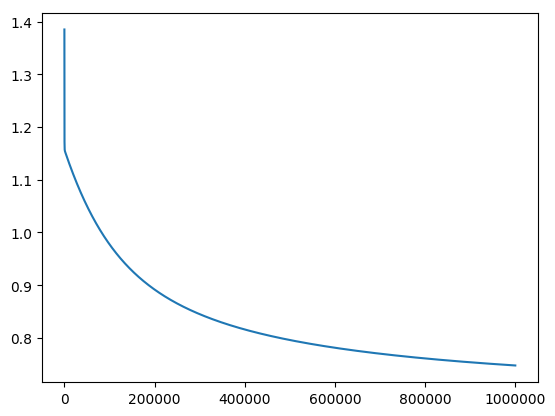

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f0ad90b7f90>